In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.signal import find_peaks, butter, lfilter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.stats import trim_mean
from os import listdir
from os.path import isfile, join
import os
from preprocessing_v2 import moving_average, runningMeanFast
%matplotlib inline

In [3]:
def moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N,mode='same')

def butter_lowpass(cutoff=5, fs=1000, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [6]:
def get_pca(path, from_path=True, data=None):
    if from_path:
        data = pd.read_csv(path, header=None).values
    amp = data[:, 1:91]

    # Filter offset
    constant_offset = np.empty_like(amp)
    filtered_data = np.empty_like(amp)
    for i in range(1, len(amp[0])):
        constant_offset[:, i] = moving_average(amp[:, i], 4000)
    filtered_data = amp - constant_offset

    # Smoothing
    for i in range(1, len(amp[0])):
        filtered_data[:, i] = moving_average(filtered_data[:, i], 10)

    # PCA
    cov_mat2 = np.cov(filtered_data.T)
    #print(cov_mat2)
    eig_val2, eig_vec2 = np.linalg.eig(cov_mat2)
    idx = eig_val2.argsort()[::-1]
    eig_val2 = eig_val2[idx]
    eig_vec2 = eig_vec2[:, idx]
    pca_data2 = filtered_data.dot(eig_vec2)

    # First 6 PCA components:
    k = 711
    plt.figure(figsize=(18, 30))
    for i in range(6):
        plt.subplot(k + i)
        Pxx, freqs, bins, im = plt.specgram(pca_data2[:, i], NFFT=256,
                                            Fs=1000, noverlap=1, cmap="jet", vmin=-100, vmax=20)
        plt.xlabel("Time[s]")
        plt.ylabel("Frequency [Hz]")
        plt.title("Spectrogram(STFT) Component {}".format(i + 1))
        plt.colorbar(im)
        # plt.xlim(0,20)
        plt.ylim(0, 80)
    #plt.show()
    
    # Spectrogram of average PCA component
    #plt.figure(figsize=(18, 10))
    new_data = np.zeros(shape=pca_data2[:, 0].shape)
    for i in range(6):
        if i not in [1]:
            continue
        new_data += pca_data2[:, i] # get 1 component
    # new_data /= 2.0
    plt.subplot(717)
    spec, f, t, im = plt.specgram(new_data, NFFT=256, Fs=1000, noverlap=1, cmap='jet', vmin=-100, vmax=20)
    plt.xlabel("Time[s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Spectrogram(STFT) combined PCA components")
    plt.colorbar(im)
    # plt.xlim(0,20)
    plt.ylim(0, 80)
    plt.show()

    return spec, f, t, data

In [7]:
# Will need this later
X, y = [],[]

In [8]:
data_dir = 'Dataset_meeting'
loc = 'loc1'
data_dir = join(data_dir, loc)
save_dir = 'processed_data_meeting'
csi_data_lst = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f))]
csi_data_lst

['Dataset_meeting/loc1/consolidated_loc1_circle.csv',
 'Dataset_meeting/loc1/consolidated_loc1_left-right.csv',
 'Dataset_meeting/loc1/consolidated_loc1_cross.csv',
 'Dataset_meeting/loc1/consolidated_loc1_up-down.csv']

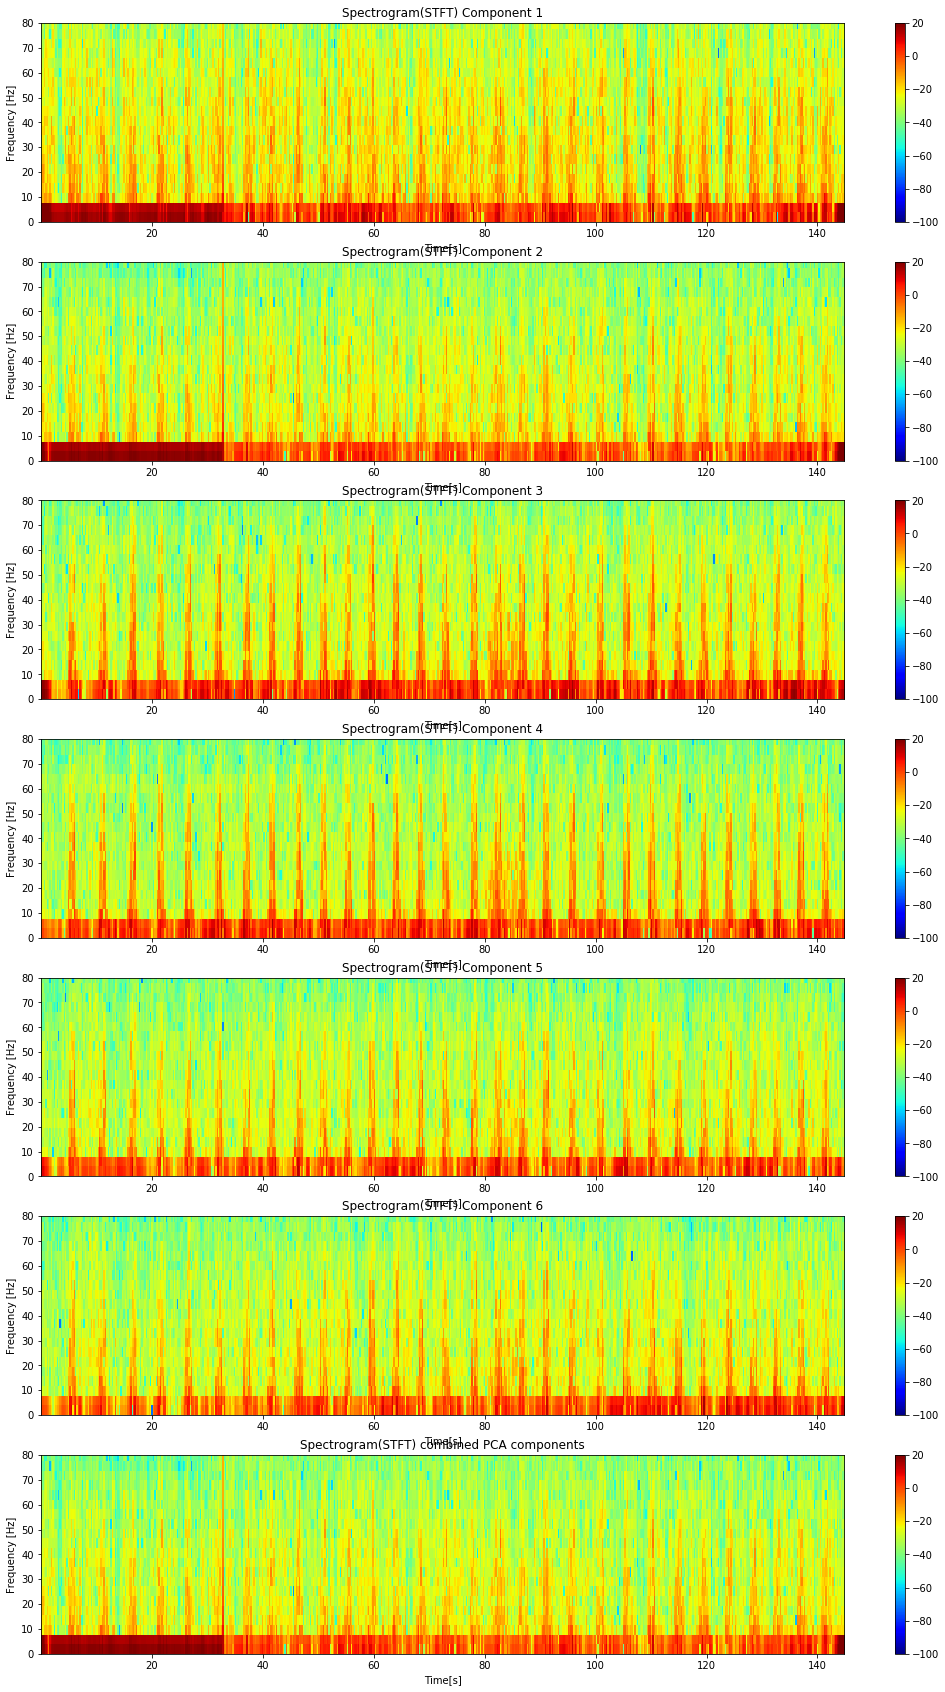

In [9]:
# Get specgram
spec, f, t, CSI = get_pca(csi_data_lst[0])

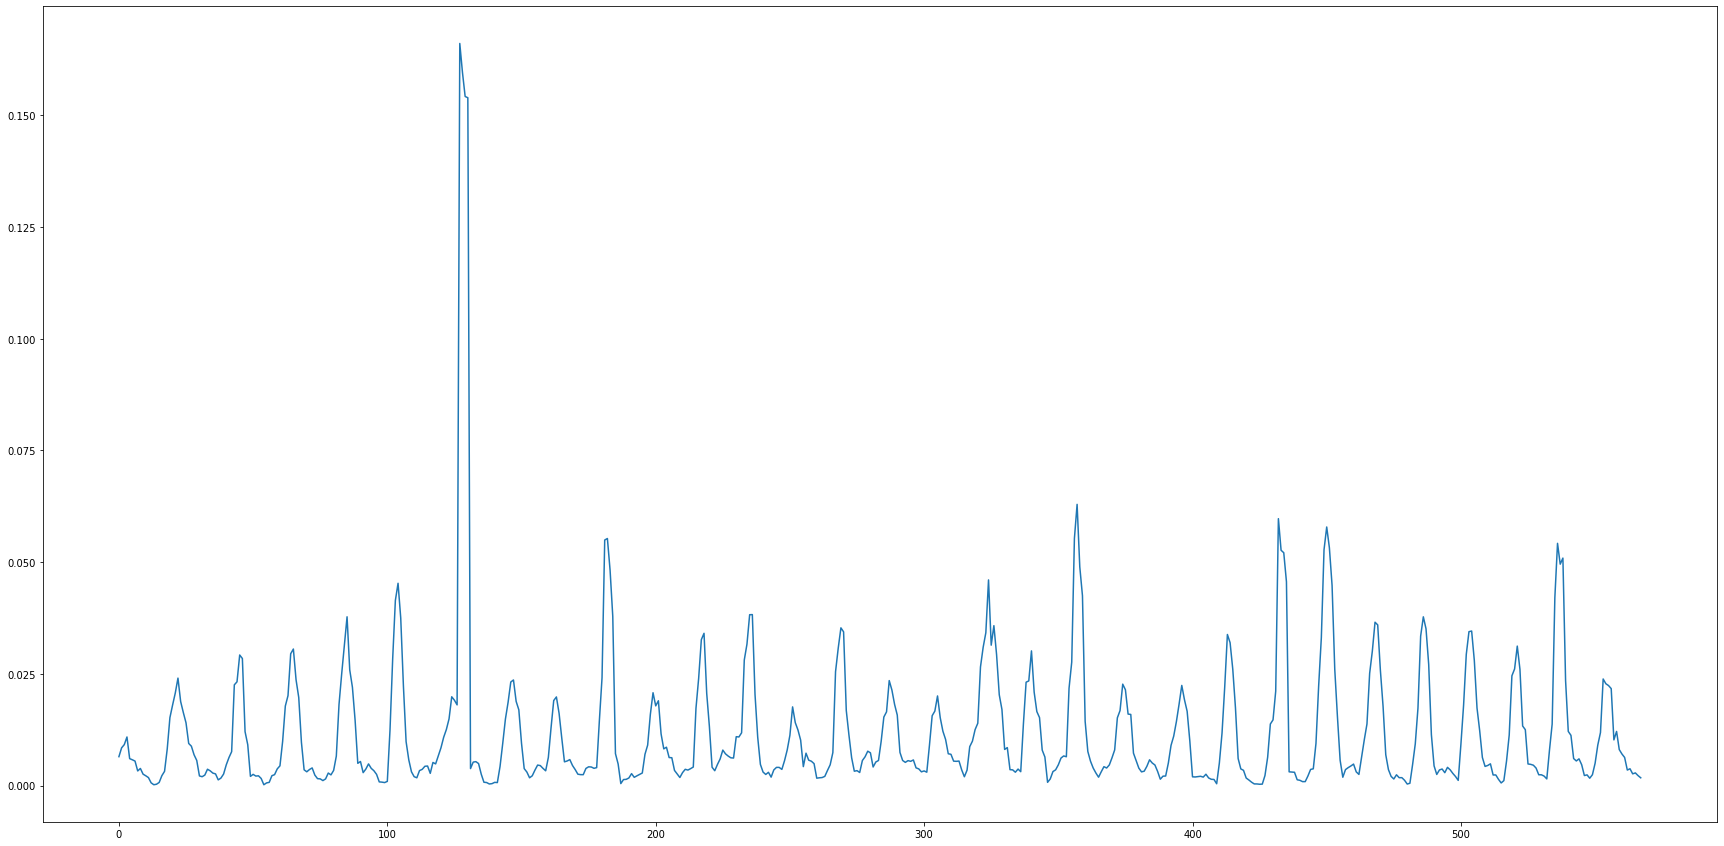

In [10]:
tm = trim_mean(spec[4:8], 0, axis=0)    #0 to keep the entirety
D = pd.Series(tm, t)
tm_mva = runningMeanFast(D,4)
plt.figure(figsize=(30, 15))
plt.plot(tm_mva)

plt.show()

In [11]:
def vizMva(distancemva, thresholdmva):
    plt.figure(figsize=(30,15))
    plt.plot(t, tm_mva)
    peaksmva, _ = find_peaks(tm_mva, distance=distancemva, threshold = thresholdmva)
    bins5peaksmva = t[peaksmva]
    plt.plot(bins5peaksmva, tm_mva[peaksmva], "x")
    
    plt.show()
    return len(peaksmva)
interact(vizMva, distancemva=widgets.IntSlider(min=0, max=25, step=1, value=10), thresholdmva=widgets.FloatSlider(min=0, max=0.0001, step=0.00001, value=0))

interactive(children=(IntSlider(value=10, description='distancemva', max=25), FloatSlider(value=0.0, descriptiâ€¦

<function __main__.vizMva(distancemva, thresholdmva)>

In [12]:
mvaPeaks, _ = find_peaks(tm_mva, distance=15, threshold=0) # change distance parameter according to above graph
print(len(mvaPeaks))
bins_mvaPeaks = t[mvaPeaks]
bins_mvaPeaks = list(map(lambda x: int(x * 1000), bins_mvaPeaks))

31


In [16]:
### GET CSI PARTITION
def get_CSI_partition(CSI, peaks, split, drop=[], cutoff=10, fs=1000):
    'get CSI partition, apply lpf, downsampling'
    lpf = butter_lowpass(cutoff=cutoff, fs=fs, order=5)
    #partition = np.empty(shape=(len(peaks), split*2, CSI.shape[1]))
    partition = np.empty(shape=(len(peaks), split*2, 90)) # 200 after downsampling
    for i in range(len(peaks)): # we assume that data collection started early enough and ended soon enough,
        # so we won't make an exception for first and last peaks in case the window goes beyond the first and
        # last indices. Otherwise, just disregard first and last peak, losing data
        #print(peaks[i]-split, peaks[i]+split)
        try:
            psi = CSI[(peaks[i]-split):(peaks[i]+split), 1:91]
            # shape of partition[i] is (4000,90), apply lpf here
            '''
            for channel  in range(psi.shape[-1]):
                tmp  = psi[:, channel]
                #edited
                tmp = lfilter(lpf[0],lpf[1], tmp)
                partition[i, :, channel]= tmp
                '''
            partition[i] = psi
        except:
            pass
    return partition
avg_split = 4000
CSI_part = get_CSI_partition(CSI, bins_mvaPeaks[1:], int(avg_split/2))
CSI_part.shape

(30, 4000, 90)

In [17]:
### DOWNSAMPLING
def downsample(array):
    new_array = []
    for i in range(len(array)):
        sample = array[i]
        t = int(len(sample)/2)
        sample = sample[(t-1000):(t+1000),]
        sample = sample[::10]
        new_array.append(sample)
    return np.array(new_array)
CSI_part = downsample(CSI_part)
CSI_part.shape

(30, 200, 90)

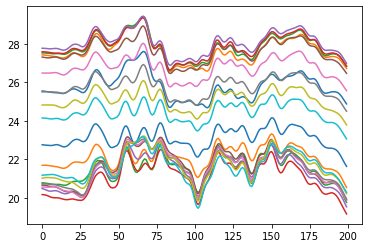

In [21]:
### OPTIONAL GRAPHING
plt.figure()
plt.plot(CSI_part[0,:,0:20])
plt.show()

In [51]:
# labeling is here, change the number to correspond to previous convention
# format: (room, location, activity)
'''
defs:
0 = up
1 = down
2 = left
3 = right
4 = circle
5 = cross
'''
lab = np.ones(shape=(CSI_part.shape[0], 3))
lab[:, 0] = 0 # room
lab[:, 1] = int(loc[-1:]) # loc

# ACTION
# single labeling
lab[:, 2] = 4

# when double labeling:
#alt = np.array([0 if i%2 == 0 else 1 for i in range(len(lab))])
#alt = np.array([2 if i%2 == 0 else 3 for i in range(len(lab))])
#lab[:, 2] = alt
lab

array([[0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.],
       [0., 9., 5.]])

In [52]:
print(CSI_part.shape)
print(lab.shape)

(24, 4000, 90)
(24, 3)


In [53]:

#np.save(join(save_dir, 'loc5_ud_X'), CSI_part)

In [54]:
#np.save(join(save_dir, 'loc5_ud_y'), lab)

In [55]:
X.append(CSI_part)
y.append(lab)

In [56]:
print(len(X), len(y))

4 4


In [57]:
def fold_left(f, seed, lst):
    if lst == []: 
        return seed
    elif len(lst) == 1:
        return f(seed, lst[0])
    else:
        return fold_left(f, f(seed, lst[0]), lst[1:])
    
def cc(a, b):
    return np.concatenate((a, b))

In [58]:
a = fold_left(cc, np.zeros(shape=(0,4000,90)), X)
b = fold_left(cc, np.zeros(shape=(0,3)), y)

In [59]:
print(a.shape, b.shape)

(149, 4000, 90) (149, 3)


In [62]:
q = np.argwhere(np.isnan(a))
q


array([], shape=(0, 3), dtype=int64)

In [63]:
dest = join(save_dir, loc)
print(dest)
if not os.path.exists(dest):
    os.mkdir(dest)
np.save(join(dest,'X.npy'), a)
np.save(join(dest,'y.npy'), b)

processed_data/loc9


In [64]:
for i in range(4):
    print(len(y[i]))

50
25
50
24


In [69]:
y

[array([[0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.],
        [0., 5., 4.]]), array([[0., 5., 2.],
        [0., 5., 3.],
        [0., 5., 2.],
        [0., 5., 3.],
        [0., 5., 2.],
        [0., 5., 3.],
        [0., 5., 2.],
        [0., 5., 3.],
        [0., 5., 2.],
        [0., 5., 3.],
        [0., 5., 2.],
        [0., 5., 3.],
        [0., 5., 2.],
        [0., 5., 3.],
        [0., 5., 2.],
        [0., 5., 3.],
        [0., 5., 2.],
        [0., 5., 3.],
        [0., 5., 2.],
        [0., 5., 3.],
        [